## 1. Understanding the Business
There is a need to predict a stroke patient from the Kaggle stroke dataset (https://www.kaggle.com/asaumya/healthcare-dataset-stroke-data). A model will be developed
followed by an evaluation of the model's performance. Effort would be made to suggest which 
features may be useful in stroke prediction.
A 2-page report would be submitted which would outline and justify the choice of pre-processing, steps taken to avoid overfitting, parameter choices and the choice of classifier / statistical modelling compared to other approaches. 

<font size = 3><strong>Understanding the problem</strong></font>
The goal is to determine if a patient suffer stroke or not. This is a supervised classification (binary).
Having false positive is not a major issue. The major challenge are the false negative. This is because a patient is not diagnosed. 
Need to test different algorithms.

Logistic regression (simple but require data cleaning)
Decision tree
Naive Bayes (suppose each feature is independant - check collinearity)
SVM
Random forest
XGBoost
Gradient Boosting
KNN
MPL

<font size = 3><strong>Import Packages</strong></font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from scipy import stats
import os
from functools import partial

%matplotlib inline

import pandas_profiling
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score

import xgboost as xgb
import lightgbm as lgb
import time

import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

import pickle
import warnings

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D
import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

## 2. Understand datasets and features

In [2]:
df = pd.read_csv('train_2v.csv', sep=',')

In [3]:
print(df.shape)
print(df.info())

(43400, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB
None


There are NaN values for bmi and smoking_status

In [4]:
df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


In [5]:
df.shape

(43400, 12)

Exploratory Data Analysis and Visualizations


In [6]:
df.describe().round(2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.00,43400.00,43400.00,43400.00,43400.00,41938.00,43400.00
mean,36326.14,42.22,0.09,0.05,104.48,28.61,0.02
std,21072.13,22.52,0.29,0.21,43.11,7.77,0.13
min,1.00,0.08,0.00,0.00,55.00,10.10,0.00
25%,18038.50,24.00,0.00,0.00,77.54,23.20,0.00
50%,36351.50,44.00,0.00,0.00,91.58,27.70,0.00
75%,54514.25,60.00,0.00,0.00,112.07,32.90,0.00
max,72943.00,82.00,1.00,1.00,291.05,97.60,1.00


Strong standard deviation for avg_glucose_level and age
Need to see if ID is unique or not (same patient seen over time

IDs

In [7]:
# Unique IDs
Numb_ID_unique=df['id'].nunique( )
print("There are ",Numb_ID_unique , "uniques IDs out of", df.shape[0])

There are  43400 uniques IDs out of 43400


In [8]:
# non unique IDs.
duplicated_ID=df[df.duplicated(subset=['id'],keep=False)]
duplicated_ID_sort=duplicated_ID.sort_values('id')
print("There are ",duplicated_ID_sort.shape[0], "duplicated IDs")
duplicated_ID_sort.head(10)

There are  0 duplicated IDs


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


No duplicates data so we can remove the column 'id'

In [9]:
# Remove the ID
df = df.drop(['id'], axis=1)
df.shape

(43400, 11)

<font size = 3><strong>Analyze the missing values (NaN)</strong></font>

In [10]:
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

Text(0.5, 1.0, 'Percent missing data by feature or label')

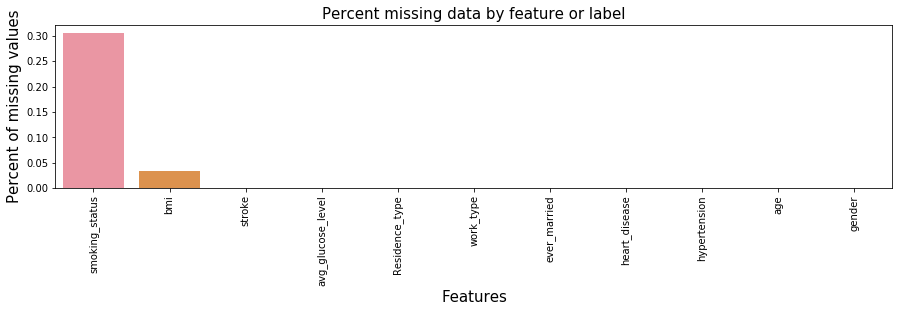

In [11]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 3))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature or label', fontsize=15)

Just 3% of BMI data are missing so we can replace them with the mean.

In [12]:
df.bmi.fillna(df.bmi.mean(),inplace=True)

30% of smoking data are missing. It is better to create a new category. This category will be named as 'unknown'. For kids below age 10, we will assume they never smoked.

In [13]:
df.smoking_status.fillna('unknown',inplace=True)

df.loc[(df['age']<=10),'smoking_status']='never smoked'

In [14]:
#gender
df[df['gender']=='Other'].shape

(11, 11)

In [15]:
df[df['gender']=='Other'].head(11)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2914,Other,26.0,0,0,No,Private,Rural,143.33,22.400000,formerly smoked,0
10768,Other,46.0,0,0,No,Private,Rural,83.28,28.605038,never smoked,0
15620,Other,27.0,0,0,No,Private,Urban,62.45,28.605038,smokes,0
15838,Other,53.0,0,0,Yes,Private,Rural,89.65,28.605038,unknown,0
19748,Other,39.0,0,0,Yes,Govt_job,Urban,95.59,32.000000,formerly smoked,0
21041,Other,19.0,0,0,No,Private,Rural,75.76,32.200000,formerly smoked,0
21192,Other,49.0,0,0,Yes,Private,Urban,94.88,37.200000,never smoked,0
24252,Other,51.0,0,0,Yes,Private,Rural,91.75,32.200000,formerly smoked,0
26199,Other,10.0,0,0,No,children,Rural,72.05,21.200000,never smoked,0
26831,Other,53.0,0,0,Yes,Govt_job,Urban,65.29,28.605038,unknown,0


In [16]:
df = df[df['gender']!='Other']

In [17]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<font size = 3><strong>Univariate Analysis</strong></font>

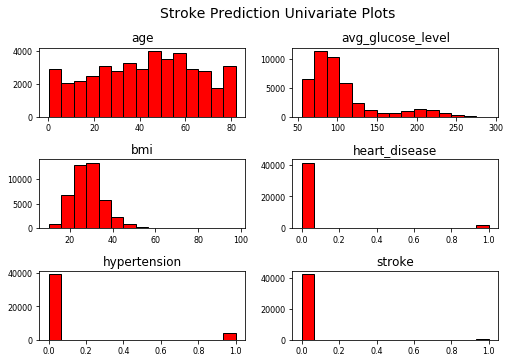

In [18]:
df.hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
rt = plt.suptitle('Stroke Prediction Univariate Plots', x=0.65, y=1.25, fontsize=14)

In [19]:
# We create a crosstabulation as input for the chi-square test of independence
crosstab=pd.crosstab(df.hypertension,df.heart_disease)   
crosstab

heart_disease,0,1
hypertension,,
0,37781,1547
1,3546,515


In [20]:
chi2result=stats.chi2_contingency(crosstab)
chi2result
print("Chi-square value:", chi2result[0],"p-value:", chi2result[1],"<0.05, degree of freedom:", chi2result[2])
print("All expected frequencies", chi2result[3],"are >5, chi2 test results are valid") 
print("We reject the null hypothesis as the p-value is less than 0.05")
print("heart_disease and hypertension are related in our data")

Chi-square value: 620.3858073088985 p-value: 6.163757036870708e-137 <0.05, degree of freedom: 1
All expected frequencies [[37458.99320104  1869.00679896]
 [ 3868.00679896   192.99320104]] are >5, chi2 test results are valid
We reject the null hypothesis as the p-value is less than 0.05
heart_disease and hypertension are related in our data


In [21]:
# We create a crosstabulation as input for the chi-square test of independence
crosstab=pd.crosstab(df.heart_disease,df.stroke)   
crosstab

stroke,0,1
heart_disease,,
0,40721,606
1,1885,177


In [22]:
chi2result=stats.chi2_contingency(crosstab)
chi2result
print("Chi-square value:", chi2result[0],"p-value:", chi2result[1], "<0.05, degree of freedom:", chi2result[2])
print("All expected frequencies", chi2result[3],"are >5, chi2 test results are valid") 
print("We reject the null hypothesis as the p-value is less than 0.05")
print("heart_disease and stroke are related in our data")

Chi-square value: 557.4652445019067 p-value: 2.9923735302785875e-123 <0.05, degree of freedom: 1
All expected frequencies [[4.05812110e+04 7.45789048e+02]
 [2.02478905e+03 3.72109521e+01]] are >5, chi2 test results are valid
We reject the null hypothesis as the p-value is less than 0.05
heart_disease and stroke are related in our data


In [23]:
# We create a crosstabulation as input for the chi-square test of independence
crosstab=pd.crosstab(df.hypertension,df.stroke)   
crosstab

stroke,0,1
hypertension,,
0,38745,583
1,3861,200


In [24]:
chi2result=stats.chi2_contingency(crosstab)
chi2result
print("Chi-square value:", chi2result[0],"p-value:", chi2result[1], "<0.05, degree of freedom:", chi2result[2])
print("All expected frequencies", chi2result[3],"are >5, chi2 test results are valid") 
print("We reject the null hypothesis as the p-value is less than 0.05")
print("hypertension and stroke are related in our data")

Chi-square value: 244.22688418519402 p-value: 4.710737057406727e-55 <0.05, degree of freedom: 1
All expected frequencies [[38618.28500311   709.71499689]
 [ 3987.71499689    73.28500311]] are >5, chi2 test results are valid
We reject the null hypothesis as the p-value is less than 0.05
hypertension and stroke are related in our data


<font size = 3><strong>Multivariate Analysis</strong></font>
We will now look at the correlation between groups of variables (pairs, multiple variables)

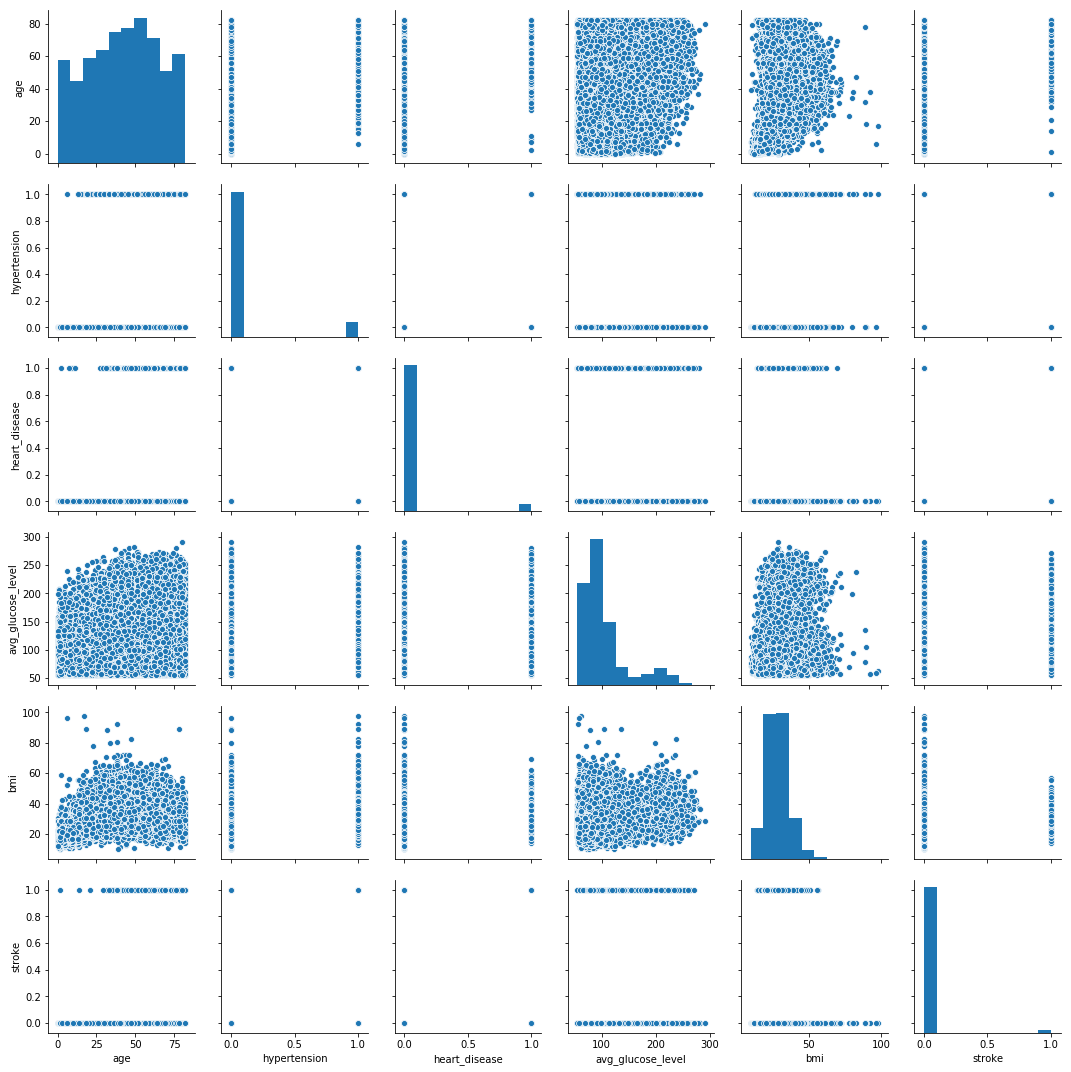

In [25]:
sns.pairplot(data=df)

<font size = 3><strong>Influence of Gender, Age, BMI on Stroke</strong></font>

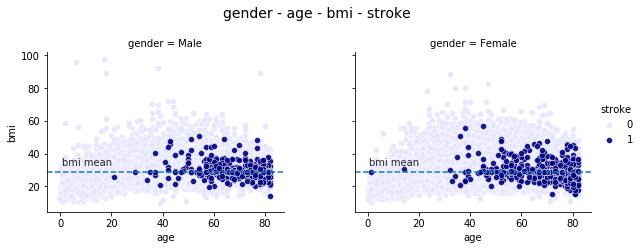

In [26]:
g = sns.FacetGrid(df, col="gender", hue='stroke', 
                  col_order=['Male', 'Female'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 2))
g.map(plt.scatter, "age", "bmi", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(28.61, ls='--')
    ax2.axhline(28.61, ls='--')
    ax1.text(0.5,33, "bmi mean")
    ax2.text(0.5,33, "bmi mean")

fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('gender - age - bmi - stroke', fontsize=14)
l = g.add_legend(title='stroke')

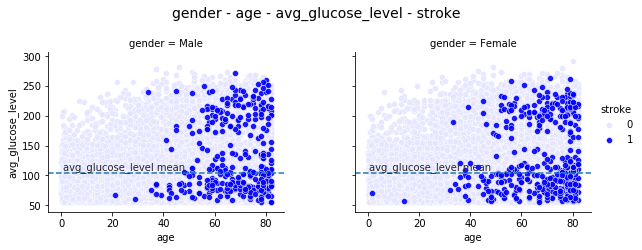

In [27]:
g = sns.FacetGrid(df, col="gender", hue='stroke', 
                  col_order=['Male', 'Female'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('blue', 2))
g.map(plt.scatter, "age", "avg_glucose_level", alpha=0.9, 
      edgecolor='white', linewidth=0.5)

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(104.48, ls='--')
    ax2.axhline(104.48, ls='--')
    ax1.text(0.5,110, "avg_glucose_level mean")
    ax2.text(0.5,110, "avg_glucose_level mean")

fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('gender - age - avg_glucose_level - stroke', fontsize=14)
l = g.add_legend(title='stroke')

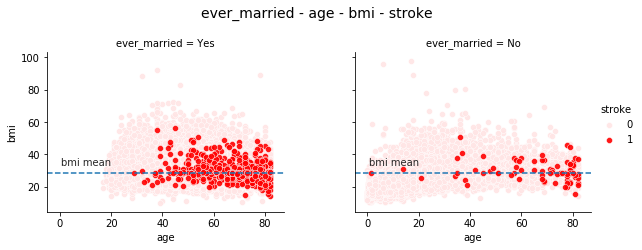

In [28]:
g = sns.FacetGrid(df, col="ever_married", hue='stroke', 
                  col_order=['Yes', 'No'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('red', 2))
g.map(plt.scatter, "age", "bmi", alpha=0.9, 
      edgecolor='white', linewidth=0.5)

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(28.61, ls='--')
    ax2.axhline(28.61, ls='--')
    ax1.text(0.5,33, "bmi mean")
    ax2.text(0.5,33, "bmi mean")

fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('ever_married - age - bmi - stroke', fontsize=14)
l = g.add_legend(title='stroke')

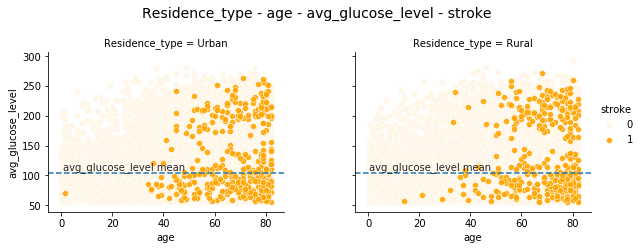

In [29]:
g = sns.FacetGrid(df, col="Residence_type", hue='stroke', 
                  col_order=['Urban', 'Rural'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('orange', 2))
g.map(plt.scatter, "age", "avg_glucose_level", alpha=0.9, 
      edgecolor='white', linewidth=0.5)

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(104.48, ls='--')
    ax2.axhline(104.481, ls='--')
    ax1.text(0.5,110, "avg_glucose_level mean")
    ax2.text(0.5,110, "avg_glucose_level mean")
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Residence_type - age - avg_glucose_level - stroke', fontsize=14)
l = g.add_legend(title='stroke')

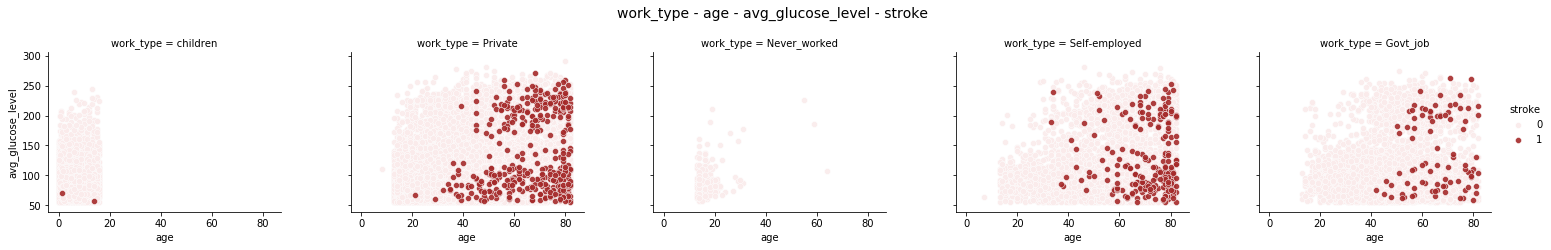

In [30]:
g = sns.FacetGrid(df, col="work_type", hue='stroke', 
                  col_order=['children', 'Private', 'Never_worked', 'Self-employed', 'Govt_job'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "age", "avg_glucose_level", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('work_type - age - avg_glucose_level - stroke', fontsize=14)
l = g.add_legend(title='stroke')

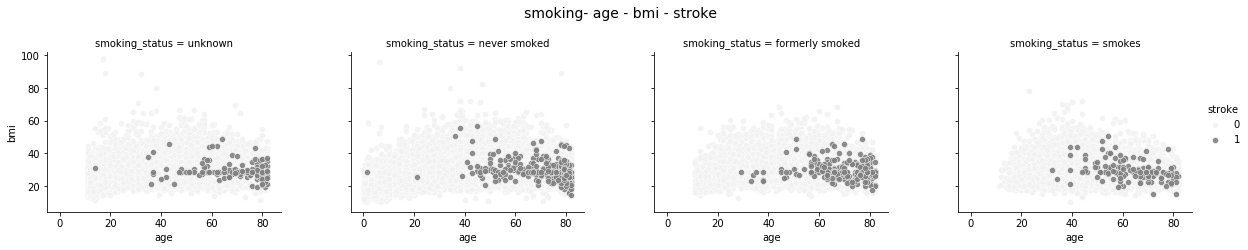

In [31]:
g = sns.FacetGrid(df, col="smoking_status", hue='stroke', 
                  col_order=['unknown','never smoked', 'formerly smoked', 'smokes'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('grey', 2))
g.map(plt.scatter, "age", "bmi", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('smoking- age - bmi - stroke', fontsize=14)
l = g.add_legend(title='stroke')

<font size = 3><strong>Correlation Matrix</strong></font>

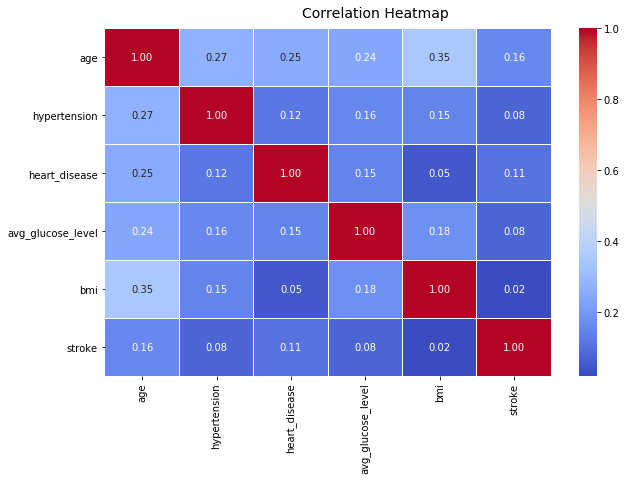

In [32]:
f, ax = plt.subplots(figsize = (10,6))
corr= df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t=f.suptitle("Correlation Heatmap",fontsize=14)

In [33]:
# Binning for BMI data
bin_ranges_bmi = [0, 18.5, 24.9, 29.9, 49.9, 100]
bin_names_bmi = ['Underweight', 'Normal weight', 'Overweight', 'Obese', 'Extr. Obese']

df['bmi_range'] = pd.cut(np.array(
                           df['bmi']), 
                           bins=bin_ranges_bmi)
                    
df['bmi_cat'] = pd.cut(np.array(
                         df['bmi']),
                         bins=bin_ranges_bmi,            
                         labels=bin_names_bmi)
#From litterature
#Underweight: BMI is less than 18.5
#Normal weight: BMI is 18.5 to 24.9
#Overweight: BMI is 25 to 29.9
#Obese: BMI is 30 to 49.9
#Extr. Obese: more than 50 (added)
#Source: https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html

<font size = 3><strong>Influence of BMI categories, Age, Glucose on Stroke</strong></font>

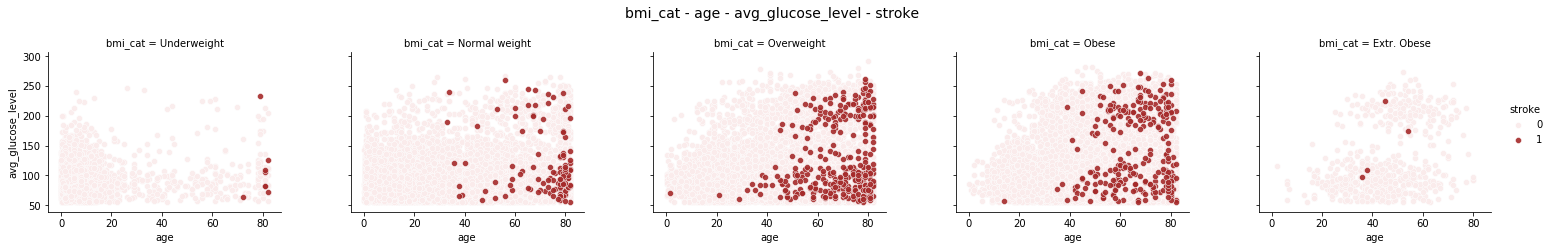

In [34]:
g = sns.FacetGrid(df, col="bmi_cat", hue='stroke', 
                  col_order=['Underweight', 'Normal weight', 'Overweight', 'Obese', 'Extr. Obese'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "age", "avg_glucose_level", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('bmi_cat - age - avg_glucose_level - stroke', fontsize=14)
l = g.add_legend(title='stroke')

In [35]:
# Binning for Avg_Glucose data
bin_ranges_avg_glucose_level = [0, 60, 140, 220, 300]
bin_names_avg_glucose_level = ['Low AG', 'Normal AG', 'High AG','Very high AG']

df['avg_glucose_range'] = pd.cut(np.array(
                           df['avg_glucose_level']), 
                           bins=bin_ranges_avg_glucose_level)
                    
df['avg_glucose_cat'] = pd.cut(np.array(
                         df['avg_glucose_level']),
                         bins=bin_ranges_avg_glucose_level,            
                         labels=bin_names_avg_glucose_level)
#From litterature
#Low: AG is less than 60
#Normal : AG is 60 to 140 (Diabete people slightly higher)
#High: AG is 140 to 220
#Extremely High: AG is 220 to 300 (category added)
#Source:  https://wa.kaiserpermanente.org/healthAndWellness/index.jhtml?item=%2Fcommon%2FhealthAndWellness%2Fconditions%2Fdiabetes%2Fa1c.html

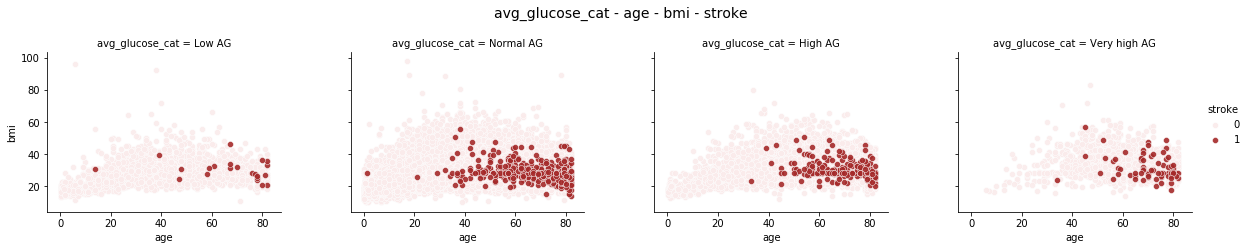

In [36]:
g = sns.FacetGrid(df, col="avg_glucose_cat", hue='stroke', 
                  col_order=['Low AG', 'Normal AG', 'High AG','Very high AG'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "age", "bmi", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('avg_glucose_cat - age - bmi - stroke', fontsize=14)
l = g.add_legend(title='stroke')

In [37]:
# Binning for Age data
bin_ranges_age = [0, 20, 40, 60, 80, 100]
bin_names_age = ['age<20', '20-40', '40-60', '60-80', '80-100']

df['age_range'] = pd.cut(np.array(
                           df['age']), 
                           bins=bin_ranges_age)
                    
df['age_cat'] = pd.cut(np.array(
                         df['age']),
                         bins=bin_ranges_age,            
                         labels=bin_names_age)

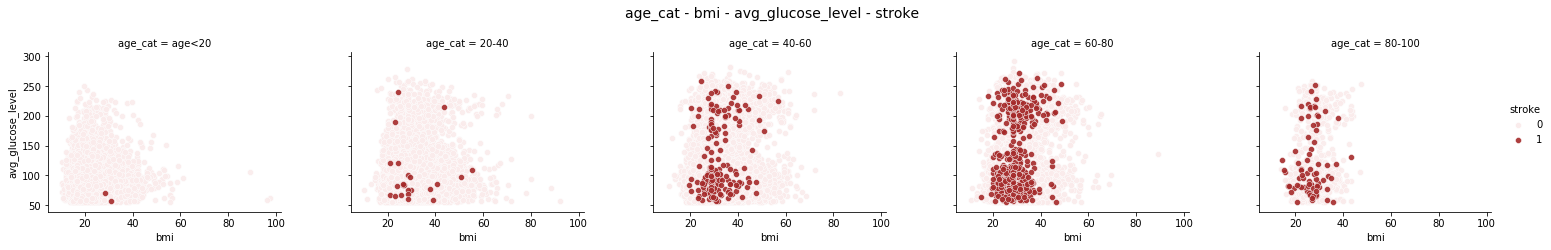

In [38]:
g = sns.FacetGrid(df, col="age_cat", hue='stroke', 
                  col_order=['age<20', '20-40', '40-60','60-80', '80-100'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "bmi", "avg_glucose_level", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('age_cat - bmi - avg_glucose_level - stroke', fontsize=14)
l = g.add_legend(title='stroke')

## 3. Data Preparation and Modelling

In [39]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_range,bmi_cat,avg_glucose_range,avg_glucose_cat,age_range,age_cat
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,never smoked,0,"(0.0, 18.5]",Underweight,"(60, 140]",Normal AG,"(0, 20]",age<20
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,"(29.9, 49.9]",Obese,"(60, 140]",Normal AG,"(40, 60]",40-60
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,never smoked,0,"(0.0, 18.5]",Underweight,"(60, 140]",Normal AG,"(0, 20]",age<20
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,"(29.9, 49.9]",Obese,"(60, 140]",Normal AG,"(60, 80]",60-80
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,unknown,0,"(18.5, 24.9]",Normal weight,"(140, 220]",High AG,"(0, 20]",age<20


In [40]:
df.dtypes

gender                 object
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
Residence_type         object
avg_glucose_level     float64
bmi                   float64
smoking_status         object
stroke                  int64
bmi_range            category
bmi_cat              category
avg_glucose_range    category
avg_glucose_cat      category
age_range            category
age_cat              category
dtype: object

In [41]:
df1 = df.iloc[:,0:11]

<font size = 3><strong>Encoding categorical data</strong></font>

In [42]:
# using get_dummies to one hot encode
df1= pd.get_dummies(df1, columns=['hypertension', 'heart_disease', 'gender', 
                                                    'ever_married','work_type','Residence_type',
                                                    'smoking_status'], drop_first=True)
cols = df1.columns.tolist()
cols= cols[4:] + cols[:4]
df1 = df1[cols] 
df1.head()

,hypertension_1,heart_disease_1,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,smoking_status_unknown,age,avg_glucose_level,bmi,stroke
0,0,0,1,0,0,0,0,1,0,1,0,0,3.0,95.12,18.0,0
1,1,0,1,1,0,1,0,0,1,1,0,0,58.0,87.96,39.2,0
2,0,0,0,0,0,1,0,0,1,1,0,0,8.0,110.89,17.6,0
3,0,0,0,1,0,1,0,0,0,0,0,0,70.0,69.04,35.9,0
4,0,0,1,0,1,0,0,0,0,0,0,1,14.0,161.28,19.1,0


In [43]:
df1.shape

(43389, 16)

In [44]:
dy = df1
dy = dy.append(dy.agg(['sum', 'mean']))
dy.tail(2)

,hypertension_1,heart_disease_1,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,smoking_status_unknown,age,avg_glucose_level,bmi,stroke
sum,4061.000000,2062.000000,17724.000000,27933.000000,177.000000,24827.000000,6793.00000,6154.000000,21751.000000,20586.000000,6560.00000,8771.000000,1.831873e+06,4.533576e+06,1.241149e+06,783.000000
mean,0.093595,0.047524,0.408491,0.643781,0.004079,0.572196,0.15656,0.141833,0.501302,0.474452,0.15119,0.202148,4.221975e+01,1.044868e+02,2.860515e+01,0.018046


In [45]:
dy.columns

Index(['hypertension_1', 'heart_disease_1', 'gender_Male', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'smoking_status_unknown', 'age', 'avg_glucose_level', 'bmi', 'stroke'],
      dtype='object')

In [46]:
X = df1.iloc[:,0:15]
y = df1.iloc[:,15:16]

<font size = 3><strong>Train/test split</strong></font>

In [47]:
#test train split
# splitting x and y into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (32541, 15)
Shape of X_test:  (10848, 15)
Shape of y_train:  (32541, 1)
Shape of y_test:  (10848, 1)


In [48]:
dy['stroke'].value_counts()

0.000000      42606
1.000000        783
0.018046          1
783.000000        1
Name: stroke, dtype: int64

<font size = 3><strong>Standardisation</strong></font>

In [49]:
num_cols=['age', 'avg_glucose_level', 'bmi']

stroke_ss = StandardScaler().fit(X_train[num_cols])

# Scale the train set numeric variable
X_train[num_cols] = stroke_ss.transform(X_train[num_cols])

# Scale the test set numeric variable
X_test[num_cols] = stroke_ss.transform(X_test[num_cols])

warnings.filterwarnings("ignore")

## 4. Model Development
<font size = 3><strong>Modelling with Logistic Regression </strong></font> Ignoring class imbalance

In [50]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
print("Training Accuracy :", logreg.score(X_train, y_train))
print("Validation Accuracy :", logreg.score(X_test, y_test))
cm = confusion_matrix(y_test, logreg_pred)
print(cm)
cr = classification_report(y_test, logreg_pred)
print(cr)

Training Accuracy : 0.9822685227866383
Validation Accuracy : 0.9810103244837758
[[10642     0]
 [  206     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10642
           1       0.00      0.00      0.00       206

    accuracy                           0.98     10848
   macro avg       0.49      0.50      0.50     10848
weighted avg       0.96      0.98      0.97     10848



<font size = 3><strong>Comments:</strong></font> Model did not predict a single stroke. There is a need to address the class imbalance using <font size = 3><strong>SMOTETomek</strong></font>

In [51]:
from imblearn.combine import SMOTETomek

In [52]:
smt = SMOTETomek(ratio='auto')
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)
X_test_smt, y_test_smt = smt.fit_sample(X_test, y_test)
#if time allows, plot_2d_space(X_train_smt, y_train_smt, 'SMOTE + Tomek links')

<font size = 3><strong>Logistic Regression</strong></font> Doing this again after balancing. Model now predicts stroke. 

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train_smt, y_train_smt)
logreg_pred = logreg.predict(X_test_smt)
print("Training Accuracy :", logreg.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", logreg.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, logreg_pred)
print(cm)
cr = classification_report(y_test_smt, logreg_pred)
print(cr)

Training Accuracy : 0.7938659729187563
Validation Accuracy : 0.7817378220801203
[[7929 2705]
 [1937 8697]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     10634
           1       0.76      0.82      0.79     10634

    accuracy                           0.78     21268
   macro avg       0.78      0.78      0.78     21268
weighted avg       0.78      0.78      0.78     21268



<font size = 3><strong>Random Forest</strong></font>

In [54]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_smt, y_train_smt)
rfc_pred = rfc.predict(X_test_smt)
print("Training Accuracy :", rfc.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", rfc.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, rfc_pred)
print(cm)
cr = classification_report(y_test_smt, rfc_pred)
print(cr)

Training Accuracy : 0.9995455115346038
Validation Accuracy : 0.8133816061688922
[[10403   231]
 [ 3738  6896]]
              precision    recall  f1-score   support

           0       0.74      0.98      0.84     10634
           1       0.97      0.65      0.78     10634

    accuracy                           0.81     21268
   macro avg       0.85      0.81      0.81     21268
weighted avg       0.85      0.81      0.81     21268



<font size = 3><strong>Decision Tree</strong></font>

In [55]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_leaf_nodes = 10, random_state = 0)
dtc.fit(X_train_smt, y_train_smt)
dtc_pred = dtc.predict(X_test_smt)
print("Training Accuracy :", dtc.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", dtc.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, dtc_pred)
print(cm)
cr = classification_report(y_test_smt, dtc_pred)
print(cr)

Training Accuracy : 0.8086603560682046
Validation Accuracy : 0.7920349821327817
[[8227 2407]
 [2016 8618]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     10634
           1       0.78      0.81      0.80     10634

    accuracy                           0.79     21268
   macro avg       0.79      0.79      0.79     21268
weighted avg       0.79      0.79      0.79     21268



<font size = 3><strong>XGBoost</strong></font>

In [56]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()
xgbfit = xgb.fit(X_train_smt, y_train_smt)
xgb_pred = xgb.predict(X_test_smt)
print("Training Accuracy :", xgb.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", xgb.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, xgb_pred)
print(cm)
cr = classification_report(y_test_smt, xgb_pred)
print(cr)

Training Accuracy : 0.892787738214644
Validation Accuracy : 0.901072033101373
[[9174 1460]
 [ 644 9990]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.90     10634
           1       0.87      0.94      0.90     10634

    accuracy                           0.90     21268
   macro avg       0.90      0.90      0.90     21268
weighted avg       0.90      0.90      0.90     21268



<font size = 3><strong>Gaussian Naive Bayes</strong></font>

In [57]:
from sklearn.naive_bayes import GaussianNB 
gaussian = GaussianNB()
gaussian.fit(X_train_smt, y_train_smt)
gaussian_pred = gaussian.predict(X_test_smt)
print("Training Accuracy :", gaussian.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", gaussian.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, gaussian_pred)
print(cm)
cr = classification_report(y_test_smt, gaussian_pred)
print(cr)

Training Accuracy : 0.6633964393179539
Validation Accuracy : 0.6605228512318977
[[ 3490  7144]
 [   76 10558]]
              precision    recall  f1-score   support

           0       0.98      0.33      0.49     10634
           1       0.60      0.99      0.75     10634

    accuracy                           0.66     21268
   macro avg       0.79      0.66      0.62     21268
weighted avg       0.79      0.66      0.62     21268



<font size = 3><strong>Support Vector Classifier</strong></font>

In [58]:
from sklearn.svm import SVC 
svc = SVC(gamma='auto')
svc.fit(X_train_smt, y_train_smt)
svc_pred = svc.predict(X_test_smt)
print("Training Accuracy :", svc.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", svc.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, svc_pred)
print(cm)
cr = classification_report(y_test_smt, svc_pred)
print(cr)

Training Accuracy : 0.8497837261785356
Validation Accuracy : 0.8296031596765093
[[8316 2318]
 [1306 9328]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     10634
           1       0.80      0.88      0.84     10634

    accuracy                           0.83     21268
   macro avg       0.83      0.83      0.83     21268
weighted avg       0.83      0.83      0.83     21268



<font size = 3><strong>K-Nearest Neighbour</strong></font>

In [59]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train_smt, y_train_smt) 
knn_pred = knn.predict(X_test_smt)
print("Training Accuracy :", knn.score(X_train_smt, y_train_smt))
print("Validation Accuracy :", knn.score(X_test_smt, y_test_smt))
cm = confusion_matrix(y_test_smt, knn_pred)
print(cm)
cr = classification_report(y_test_smt, knn_pred)
print(cr)

Training Accuracy : 0.9992320712136409
Validation Accuracy : 0.578991912732744
[[10215   419]
 [ 8535  2099]]
              precision    recall  f1-score   support

           0       0.54      0.96      0.70     10634
           1       0.83      0.20      0.32     10634

    accuracy                           0.58     21268
   macro avg       0.69      0.58      0.51     21268
weighted avg       0.69      0.58      0.51     21268



<font size = 3><strong>Spot checking algorithms using cross-validation</strong></font>

In [60]:
start_time = time.time()
# Spot Check Algorithms
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
#Xg-Boost Classifier



models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('RFC', RandomForestClassifier()))
models.append(('DTC', DecisionTreeClassifier(max_leaf_nodes = 10, random_state = 0)))
models.append(('XGB', XGBClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 2)))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('MPL', MLPClassifier()))

   

# evaluate each model in turn
results = []
names = []
for name, model in models: 
    kfold = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X_train_smt, y_train_smt, cv=kfold,)
    results.append(cv_results)
    
    
names.append(name)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

print("Execution time: " + str((time.time() - start_time)) + ' ms')

MPL: 0.926170 (0.035713)
Execution time: 1799.0348920822144 ms


In [61]:
print(models)

[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)), ('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)), ('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
            

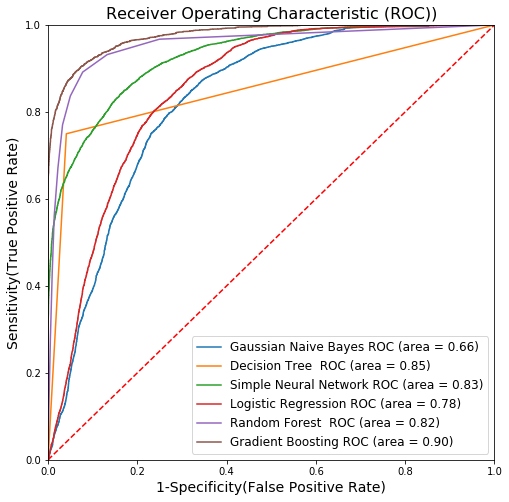

Execution time: 83.9538905620575 ms


In [67]:

start_time = time.time()

plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
    
    
{
    'label': 'Gaussian Naive Bayes',
    'model': GaussianNB(),
},
    
{
    'label': 'Decision Tree ',
    'model': DecisionTreeClassifier(),
},   

{
    'label': 'Simple Neural Network',
    'model': MLPClassifier(),
},
  
    
    
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
    
   
 
    
{
    'label': 'Random Forest ',
    'model': RandomForestClassifier(),
},  
 
     
    
#{
 #   'label': 'Support Vector Machine',   
  #  'model': SVC(),
#},   
    
    
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
    
 
    
]



# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_smt, y_train_smt) # train the model
    y_pred=model.predict(X_test_smt) # predict the test data
# Compute False postive rate, and True positive rate
    #if model==SVC():
     #   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.decision_function(X_test_smt)[:,1])
      #  model.probability = True
    #else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1])
    
# Calculate Area under the curve to display on the plot
    #if model==SVC():
     #   auc = metrics.roc_auc_score(y_test_smt,model.predict(X_test_smt))
      #  model.probability = True
    #else:
    auc = metrics.roc_auc_score(y_test_smt,y_pred)
    #auc = metrics.roc_auc_score(y_test_smt,model.predict(X_test_smt))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)', fontsize=14)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC))', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

<font size = 3><strong>Model performance based on ROC plot.</strong></font> This will be given priority in this work because it a supervised binary classification problem.

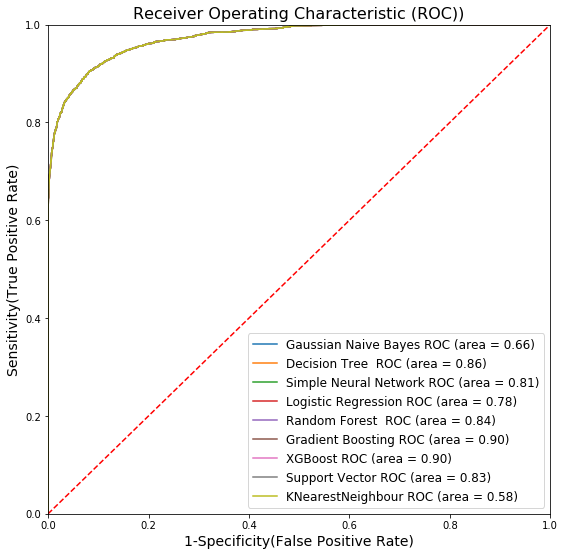

Execution time: 236.9974720478058 ms


In [66]:
start_time = time.time()

plt.figure(figsize=(9,9))

# Add the models to the list that you want to view on the ROC plot
models = [   
{
    'label': 'Gaussian Naive Bayes',
    'model': GaussianNB(),
},  
{
    'label': 'Decision Tree ',
    'model': DecisionTreeClassifier(),
},   
{
    'label': 'Simple Neural Network',
    'model': MLPClassifier(),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},    
{
    'label': 'Random Forest ',
    'model': RandomForestClassifier(),
},      
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'XGBoost',
    'model': XGBClassifier(),
},
{
    'label': 'Support Vector',
    'model': SVC(gamma='auto'),
},
{
    'label': 'KNearestNeighbour',
    'model': KNeighborsClassifier(n_neighbors = 2),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_smt, y_train_smt) # train the model
    y_pred=model.predict(X_test_smt) # predict the test data

    #fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1])
    
    auc = metrics.roc_auc_score(y_test_smt,y_pred)

    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)', fontsize=14)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC))', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best model is <font size = 3><strong>Gradient Boosting and XGBoost</strong></font> with <font size = 3><strong>ROC = 0.90.</strong></font> The model will be tuned and comparison will be made. Gradient Boosting will be selected as XGBoost works on the framework of Gradient Boosting.
## 5. Model Tuning

In [68]:
#Gradient boosting after tuning
start_time = time.time()
tuned = GradientBoostingClassifier(learning_rate=1.0,n_estimators=600,min_samples_split=0.04, max_depth=8 , max_features=12, random_state=10)

gbctunefit = tuned.fit(X_train_smt,y_train_smt)
pred=tuned.predict(X_test_smt)
print('Accuracy of the tuned GBM on test set: {:.3f}'.format(tuned.score(X_test_smt, y_test_smt)))
print(classification_report(y_test_smt, pred))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Accuracy of the tuned GBM on test set: 0.956
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10634
           1       0.97      0.94      0.96     10634

    accuracy                           0.96     21268
   macro avg       0.96      0.96      0.96     21268
weighted avg       0.96      0.96      0.96     21268

Execution time: 116.14131617546082 ms


<font size = 3><strong>Gradient boosting with tuning</strong></font>
note: source of the code: article from Medium.
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

<font size = 3><strong>Optimisation of the learning rate</strong></font>

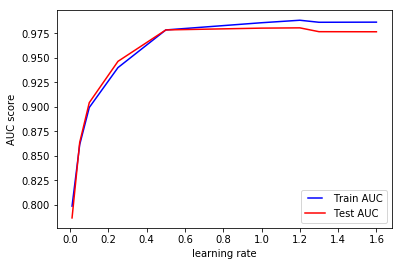

Execution time: 99.0385901927948 ms


In [69]:
start_time = time.time()
learning_rates = [1.6, 1.3, 1.2, 1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])  
   #roc_auc = auc(fpr, tpr)
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   #roc_auc = auc(fpr, tpr)
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, color='blue', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Optimum learning rate is 1.0

<font size = 3><strong>N_estimators optimization</strong></font>(takes some time)

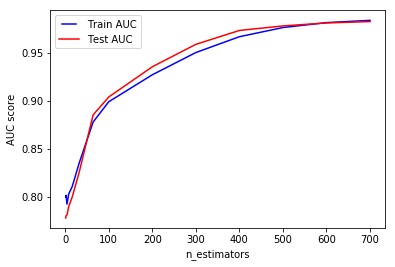

Execution time: 288.13022661209106 ms


In [70]:
#N_estimators optimization (this takes some time)
start_time = time.time()
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600, 700]

train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, color='blue', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

It looks like 600 trees is close to an optimum.

<font size = 3><strong>Optimization of the depth of the tree</strong></font>(Takes up to 15 minutes)

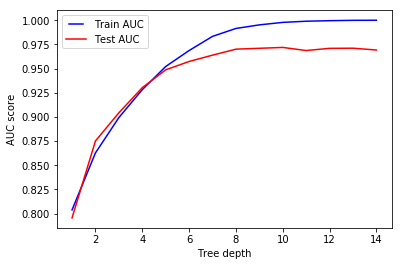

Execution time: 985.2904040813446 ms


In [71]:
start_time = time.time()
max_depths = np.linspace(1, 14, 14, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, color='blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

It looks like 8 trees depth is close to an optimum

<font size = 3><strong>Optimization of the min_samples_split</strong></font>

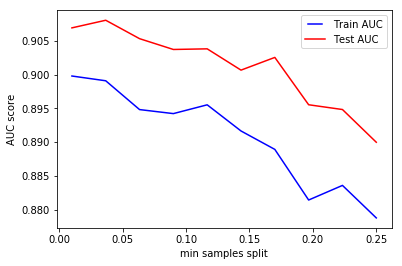

Execution time: 91.85503816604614 ms


In [72]:
start_time = time.time()
min_samples_splits = np.linspace(0.01, 0.25, 10, endpoint=True)

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)
   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D


line1, = plt.plot(min_samples_splits, train_results, color='blue', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')


4% seems optimal parameter

<font size = 3><strong>Optimization of the min_samples_leaf</strong></font>

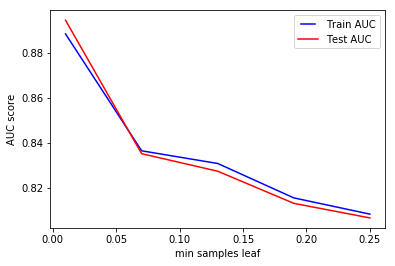

Execution time: 39.55730485916138 ms


In [73]:
start_time = time.time()
min_samples_leafs = np.linspace(0.01, 0.25, 5, endpoint=True)

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, color='blue', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

We should not enter any parameters. We are overfitting.

<font size = 3><strong>Optimization of the max_features</strong></font>

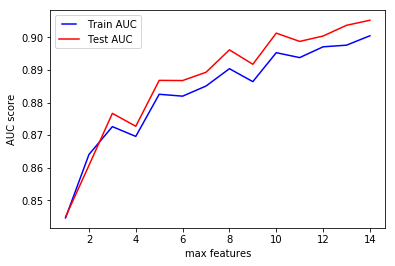

Execution time: 82.07463145256042 ms


In [74]:
start_time = time.time()
max_features = list(range(1,X_train_smt.shape[1]))

train_results = []
test_results = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D


line1, = plt.plot(max_features, train_results, color='blue', label='Train AUC')
line2, = plt.plot(max_features, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

14 features is probably close to optimum

<font size = 3><strong>Comparing the tuned/untuned GradientBoosting model using the ROC plot </strong></font>

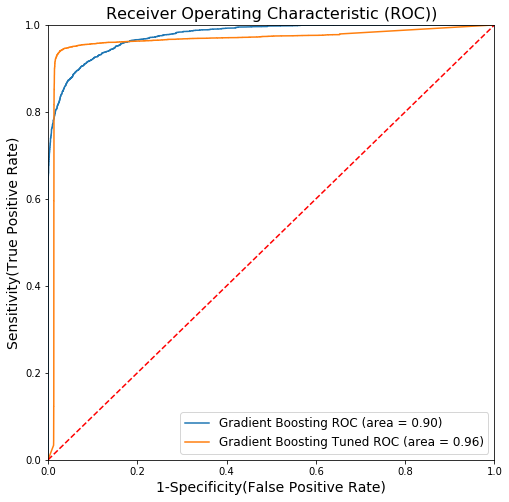

Execution time: 109.45298767089844 ms


In [75]:
start_time = time.time()
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [    
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},     
{
    'label': 'Gradient Boosting Tuned',
    'model': GradientBoostingClassifier(learning_rate=1.0,n_estimators=600,
            min_samples_split=0.04, max_features=12, max_depth=8, random_state=10),
}  
]
# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_smt, y_train_smt) # train the model
    y_pred=model.predict(X_test_smt) # predict the test data
    fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1])
    
    auc = metrics.roc_auc_score(y_test_smt,y_pred)

# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)', fontsize=14)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC))', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

## 6. Feature Importance

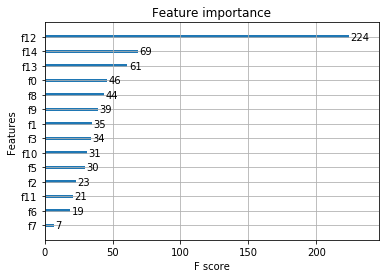

In [76]:
#plot feature importance
#This shows the importance of each features in determining the model
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgbfit)
pyplot.show()

<font size = 3><strong>Age</strong></font> is the most important feature to predict a stroke patient. Other features, <font size = 3><strong>bmi and average glucose level</strong></font> are also important.

f12 = 'age' 
f14 = 'bmi' 
f13 = 'avg_glucose_level'
f8 = 'Residence_type_Urban'
f0 = 'hypertension_1'
f9 = 'smoking_status_never smoked'
f3 = 'ever_married_Yes'
f5 = 'work_type_Private'
f10 = 'smoking_status_smokes'
f1 = 'heart_disease_1'
f2 = 'gender_Male'
f11 = 'smoking_status_unknown'
f6 = 'work_type_Self-employed'
f7 = 'work_type_children'